In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import IPython
import re
import json
from time import sleep
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('bmh')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from difflib import SequenceMatcher
import spacy
from langchain.text_splitter import RecursiveCharacterTextSplitter  
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

### **Funções** 

In [2]:
def minute_json(date_minute: str):
    """
    Realiza o web scraping das atas do COPOM.

    Parameters:
    date_minute (str): data de publicação no formato 'ddmmyyyy'.

    Returns:
    Objeto json do texto do COPOM.

    """
    url = f'https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/principal?filtro=IdentificadorUrl%20eq%20%27{date_minute}%27'
        
    headers = {
        "authority": "www.bcb.gov.br",
        "accept": "application/json, text/plain, */*",
        "accept-language": "pt-BR,pt;q=0.9",
        "cookie": "TS01d9825e=012e4f88b36cce3651c602c46f3e3dcf2c6e53409aad20d4028657ad6c0ce74f163bd591ec1ebae4c2224d16a5510b53756786b3b0; dtLatC=1; dtPC=-; TS01c46804=012e4f88b3da9e1e50438b217c16cd55dd2e13e2ebe839f4e95c012790098b9fb734a1d9fab097738b4c355d9c8a444d65d548285629cdca0e66b95ab0bfd7ecc10387d2b4cc65a5e23ab422e6946c0e01e97c458a; dtCookie=v_4_srv_1_sn_1BEC291D8A0D6B90B90E0418D5AC1813_perc_100000_ol_0_mul_1_app-3Asgs_1_app-3A262a693a3e337a24_1^|c2dzfDE; dtSa=true^%^7CKD17^%^7C-1^%^7Ctexto^%^7C-^%^7C1693916845380^%^7C116732625_395^%^7Chttps^%^3A^%^2F^%^2Fwww3.bcb.gov.br^%^2Fsgspub^%^2Flocalizarseries^%^2FlocalizarSeries.do^%^3Fmethod^%^3DprepararTelaLocalizarSeries^%^7CSGS^%^20-^%^20Sistema^%^20Gerenciador^%^20de^%^20S^%^C3^%^A9ries^%^20Temporais^%^7C1693916734678^%^7C",
        "if-none-match": "W/^\^2bc4b976-98e8-41ba-97cc-ebf522d9a013^^",
        "referer": "https://www.bcb.gov.br/en/publications/copomminutes",
        "sec-ch-ua": "^\^Chromium^^;v=^\^116^^, ^\^Not"
    }

    r = requests.request("GET", url, headers=headers)
    data = r.json()

    # Título da ata -> '255th Meeting - June 20-21, 2023'
    titulo_minute = data['conteudo'][0]['Titulo']
    # Selecionando apenas o nº da ata
    num_minute = re.findall(r'(\d+)(?:st|nd|rd|th)', titulo_minute)[0]

    # Texto com elementos HTML (c/ elementos HTML) -> Exemplo: '<div id="atacompleta"><div id="ataconteudo"><h3 class="secao">A) Update of economic outlook and Copom’s scenario<sup>1</sup></h3><p class="paragrafo">1. 
    text_minute = data['conteudo'][0]['OutrasInformacoes']

    # Usando o BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(text_minute, 'html.parser')
    # Extraindo o texto principal sem elementos HTML
    minute_text = soup.get_text()

    # Criando um dicionário com uma chave para o texto p/ transformar em um arquivo JSON
    dados = {f'minute_{num_minute}': minute_text}

    with open(f'C://Users//vitor//projetos_python//python_b3//nlp_copom_fomc//copom//minutes-json//minute_{num_minute}.json', 'w', encoding='utf-8') as arquivo_json:
        json.dump(dados, arquivo_json)
    
    sleep(2)


def minute_copom(text_minute: str):
    """
    Formatando o texto do minute em seis partes: completo, título 'A', título 'B', título 'C', título 'D' e notas do rodapé.
    Essa função serve apenas até a ata 246 até a mais atual.

    Parameters:
    text_minute: texto do minute publicado pelo BC.

    Returns:
    Dataframes do texto do minute (completo, título 'A', título 'B', título 'C', título 'D')
    
    """
    # Descobrindo a posição (index) da 1º palavra dos títulos de cada arquivo 'A)', 'B)', 'C)', 'D)'
    word_a = 'A)'
    position_a_init = text_minute.find(word_a)

    word_b = 'B)'
    position_b_init = text_minute.find(word_b)  

    word_c = 'C)'
    position_c_init = text_minute.find(word_c)

    word_d = 'D)'
    position_d_init = text_minute.find(word_d)

    word_footnote = 'Footnotes'
    position_footnote_init = text_minute.find(word_footnote)

    # Tamanho do título. Isso servirá para eu somar com a posição inicial de cada título ('A)', 'B)', 'C)', 'D)')
    # Com isso, os textos de cada título se iniciaram já no tópico ('1. The global environment remains...')
    # E não mais no título+tópico ('A) Update of economic outlook and Copom’s scenario11. The global environment remains...')
    len_titulo_a = len('A) Update of economic outlook and Copom’s scenario1')
    len_titulo_b = len('B) Scenarios and risk analysis')
    len_titulo_c = len('C) Discussion about the conduct of monetary policy')
    len_titulo_d = len('D) Monetary policy decision')

    # Minute completo não editado
    complete_minute = text_minute[:]
    #len_complete_minute = len(complete_minute)

    # A) Update of economic outlook and Copom's scenario
    minute_a = text_minute[position_a_init + len_titulo_a: position_b_init]
    #len_minute_a = len(minute_a)

    # B) Scenarios and risk analysis
    minute_b = text_minute[position_b_init + len_titulo_b : position_c_init]
    #len_minute_b = len(minute_b)

    # C) Discussion about the conduct of monetary policy
    minute_c = text_minute[position_c_init + len_titulo_c : position_d_init]
    #len_minute_c = len(minute_c)

    # D) Monetary policy decision
    minute_d = text_minute[position_d_init + len_titulo_d : position_footnote_init]
    #len_minute_d = len(minute_d)

    # Footnote
    minute_footnote = text_minute[position_footnote_init:]

    # Os tópicos que estão no meio do texto tem esse padrão que é estar entre dois pontos ('.2' -> ex:'...by emerging countries.2. Regarding the domestic...)
    # Usando o regex, eu consigo achar esse padrão ('.número.') e quebrar a linha antes do número
    minute_a = re.sub(r'\.(\d+\.)', r'\n\1', minute_a)
    minute_b = re.sub(r'\.(\d+\.)', r'\n\1', minute_b)
    minute_c = re.sub(r'\.(\d+\.)', r'\n\1', minute_c)
    minute_d = re.sub(r'\.(\d+\.)', r'\n\1', minute_d)

    # Após fazer a quebra entre os tópicos, o tópico anterior acaba ficando sem um ponto final na frase. 
    # Adicionando um ponto final nos tópicos que vem antes de uma quebra de linha, exceto no último tópico
    topicos_a = minute_a.split('\n')
    topicos_b = minute_b.split('\n')
    topicos_c = minute_c.split('\n')
    topicos_d = minute_d.split('\n')

    topicos_a_formatado = [topico + '.' if i < len(topicos_a) - 1 else topico for i, topico in enumerate(topicos_a)]
    topicos_b_formatado = [topico + '.' if i < len(topicos_b) - 1 else topico for i, topico in enumerate(topicos_b)]
    topicos_c_formatado = [topico + '.' if i < len(topicos_c) - 1 else topico for i, topico in enumerate(topicos_c)]
    topicos_d_formatado = [topico + '.' if i < len(topicos_d) - 1 else topico for i, topico in enumerate(topicos_d)]

    # Juntando os tópicos novamente em um único texto para cada título
    minute_a = '\n'.join(topicos_a_formatado)
    minute_b = '\n'.join(topicos_b_formatado)
    minute_c = '\n'.join(topicos_c_formatado)
    minute_d = '\n'.join(topicos_d_formatado)

    # Com todos os títulos topificados corretamente, juntando todos os títulos em apenas um texto (minute completo editado)
    complete_minute_final = minute_a + '\n' + minute_b + '\n' + minute_c + '\n' + minute_d

    return complete_minute_final, minute_a, minute_b, minute_c, minute_d 


def minute_copom_v2(text_minute: str):
    """
    Formatando o texto do minute em seis partes: completo, título 'A', título 'B', título 'C', título 'D' e notas do rodapé.
    Nessa função, eu estou mudando manualmente os títulos da ata.

    Parameters:
    text_minute: texto do minute publicado pelo BC.

    Returns:
    Dataframes do texto do minute (completo, título 'A', título 'B', título 'C', título 'D')
    
    """
    # Descobrindo a posição (index) da 1º palavra dos títulos de cada arquivo 'A)', 'B)', 'C)', 'D)'
    word_a = 'A)'
    position_a_init = text_minute.find(word_a)

    word_b = 'B)'
    position_b_init = text_minute.find(word_b)  

    word_c = 'C)'
    position_c_init = text_minute.find(word_c)

    word_d = 'D)'
    position_d_init = text_minute.find(word_d)

    word_footnote = 'Footnotes'
    position_footnote_init = text_minute.find(word_footnote)

    # Minute completo não editado
    complete_minute = text_minute[:]
    #len_complete_minute = len(complete_minute)

    # A) Update of economic outlook and Copom's scenario
    minute_a = text_minute[position_a_init : position_b_init]
    #len_minute_a = len(minute_a)

    # B) Scenarios and risk analysis
    minute_b = text_minute[position_b_init : position_c_init]
    #len_minute_b = len(minute_b)

    # C) Discussion about the conduct of monetary policy
    minute_c = text_minute[position_c_init : position_d_init]
    #len_minute_c = len(minute_c)

    # D) Monetary policy decision
    minute_d = text_minute[position_d_init : position_footnote_init]
    #len_minute_d = len(minute_d)

    # Footnote
    minute_footnote = text_minute[position_footnote_init:]

    # Os tópicos que estão no meio do texto tem esse padrão que é estar entre dois pontos ('.2' -> ex:'...by emerging countries.2. Regarding the domestic...)
    # Usando o regex, eu consigo achar esse padrão ('.número.') e quebrar a linha antes do número
    minute_a = re.sub(r'\.(\d+\.)', r'\n\1', minute_a)
    minute_b = re.sub(r'\.(\d+\.)', r'\n\1', minute_b)
    minute_c = re.sub(r'\.(\d+\.)', r'\n\1', minute_c)
    minute_d = re.sub(r'\.(\d+\.)', r'\n\1', minute_d)

    # Após fazer a quebra entre os tópicos, o tópico anterior acaba ficando sem um ponto final na frase. 
    # Adicionando um ponto final nos tópicos que vem antes de uma quebra de linha, exceto no último tópico
    topicos_a = minute_a.split('\n')
    topicos_b = minute_b.split('\n')
    topicos_c = minute_c.split('\n')
    topicos_d = minute_d.split('\n')

    topicos_a_formatado = [topico + '.' if i < len(topicos_a) - 1 else topico for i, topico in enumerate(topicos_a)]
    topicos_b_formatado = [topico + '.' if i < len(topicos_b) - 1 else topico for i, topico in enumerate(topicos_b)]
    topicos_c_formatado = [topico + '.' if i < len(topicos_c) - 1 else topico for i, topico in enumerate(topicos_c)]
    topicos_d_formatado = [topico + '.' if i < len(topicos_d) - 1 else topico for i, topico in enumerate(topicos_d)]

    # Juntando os tópicos novamente em um único texto para cada título
    minute_a = '\n'.join(topicos_a_formatado)
    minute_b = '\n'.join(topicos_b_formatado)
    minute_c = '\n'.join(topicos_c_formatado)
    minute_d = '\n'.join(topicos_d_formatado)

    # Com todos os títulos topificados corretamente, juntando todos os títulos em apenas um texto (minute completo editado)
    complete_minute_final = minute_a + '\n' + minute_b + '\n' + minute_c + '\n' + minute_d

    return complete_minute_final, minute_a, minute_b, minute_c, minute_d 


def wordcloud_copom(minute: str):
    """
    Criação do wordcloud do texto da ata do COPOM.

    Parameters:
    minute (str): texto da ata do COPOM.

    Returns:
    Figura do wordcloud da ata do COPOM.
    """
    # Transformando todo o texto da ata em letra minúscula
    minute_text = minute.lower()

    # Plotando o wordcloud
    plt.figure(figsize=(15,15))
    wc = WordCloud(background_color="purple", stopwords = STOPWORDS, max_words=50, max_font_size= 300,  width=1600, height=800)
    wc.generate(minute_text)
    plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
    plt.axis('off')

    return plt.show();


def text_splitter(minute: str):
    """
    Separa o texto em várias partes.

    Parameters:
    minute (str): texto da ata do COPOM.

    Returns:
    Retorna as "partes" do texto separados dentro de uma lista.

    NOTE:
    Essa função 'RecursiveCharacterTextSplitter' separa o texto bem parecido com a função do nltk 'sent_tokenize()'.
    Porém, essa função não separa os números dos tópicos do texto.
    Exemplo: 'RecursiveCharacterTextSplitter' -> ['1. The global environment remains uncertain, with some disinflation at the margin but ...']
             'sent_tokenize' -> ['1.', 'The global environment remains uncertain, with some disinflation at the margin but ...']

    """
    # https://github.com/langchain-ai/text-split-explorer
    length_function = len

    # The default list of split characters is [\n\n, \n, " ", ""]
    # Tries to split on them in order until the chunks are small enough
    # Keep paragraphs, sentences, words together as long as possible
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=1000, 
        chunk_overlap=200,
        length_function=length_function,
    )

    text = minute
    splits = splitter.split_text(text)

    return splits


def sentiment_score(sentence: str):
  """
  Análise de sentimento do texto da ata do COPOM. Utiliza um modelo específico para finanças de análise de sentimento.
  Modelo utilizado: https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis

  Parameters:
  sentence (str): texto da ata do COPOM.

  Returns:
  Retorna o sentimetno do texto da ata do COPOM - pode ser positivo, negativo ou neutro.

  """
  tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

  model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)

  nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

  results = nlp(sentence)
  
  return results[0]['label']


def sentiment_score_v2(sentence: str):
  """
  Análise de sentimento do texto da ata do COPOM. Utiliza um modelo específico para finanças de análise de sentimento.
  Modelo utilizado: https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

  Parameters:
  sentence (str): texto da ata do COPOM.

  Returns:
  Retorna o sentimetno do texto da ata do COPOM - pode ser positivo, negativo ou neutro
  """
  tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
  model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
  
  nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

  results = nlp(sentence)
  
  return results[0]['label']


def text_splitter_sentiment_analysis(minute: str):
    """
    Separa o texto em sentenças menores e faz a análise de sentimento de cada uma delas.

    Parameters:
    minute (str): texto da ata do COPOM.

    Return:
    Retorna o nº total de sentenças, quantas sentenças foram positivas, neutras ou negativas.
    
    """
    # Separando o texto em várias sentenças menores
    length_function = len
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=1000, 
        chunk_overlap=200,
        length_function=length_function,
    )
    text = minute
    sentences = splitter.split_text(text)

    # Modelo de análise de sentimento
    model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
    tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
    nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    # Iterando sobre cada sentença
    lst_sentiment = []
    for sentence in sentences:
        results = nlp(sentence)
        lst_sentiment.append(results)
    # Essa lista ('lst_sentiment) retorna uma lista que contém outras listas que contém um dicionário
    # [[{'label': 'neutral', 'score': 0.9996999502182007}],[{'label': 'neutral', 'score': 0.7167808413505554}],[{'label': 'positive', 'score': 0.9969612956047058}]]

    # Inicializando contadores para cada sentimento
    count_positive = 0
    count_negative = 0
    count_neutral = 0

    # Iterando sobre as listas de sentimentos e contando a ocorrência de cada sentimento
    for sentence_sentiments in lst_sentiment:
        for sentiment_dict in sentence_sentiments:
            label = sentiment_dict['label']
            if label == 'positive':
                count_positive += 1
            elif label == 'negative':
                count_negative += 1
            elif label == 'neutral':
                count_neutral += 1

    print(f'De {len(lst_sentiment)} sentenças:')
    print(f'- Nº de sentenças positivas: {count_positive}')
    print(f'- Nº de sentenças negativas: {count_negative}')
    print(f'- Nº de sentenças neutras: {count_neutral}')


def similaridade_sentencas(minutes_1: str, minutes_2: str):
    """
    Procurando as sentenças similares entre as atas do COPOM.

    Parameters:
    minutes_1 (str): ata do COPOM.
    minutes_2 (str): ata do COPOM.

    Returns:
    Retorna o nº de tópicos de cada ata e as sentenças que são similares.

    """
    # Tokenizando as sentenças
    sentences_1 = nltk.sent_tokenize(minutes_1)
    sentences_2 = nltk.sent_tokenize(minutes_2)

    # Usando regex p/ encontrar as strings dos tópicos do texto ('4.', '5.', '6.', '7.' ...)
    padrao = r'^\d+\.$'
    # Selecionando as strings que correspondem aos tópicos do texto
    num_topicos_1 = [string for string in sentences_1 if re.match(padrao, string)]
    num_topicos_2 = [string for string in sentences_2 if re.match(padrao, string)]
    print(f'O texto possui {len(num_topicos_1)} tópicos.')
    print(f'O texto possui {len(num_topicos_2)} tópicos.')
    print('-'*30)

    # Adicionando as senteças tokenizadas em uma lista
    lst_sent_1 = [sentence_1 for sentence_1 in sentences_1]
    lst_sent_2 = [sentence_2 for sentence_2 in sentences_2]

    # Encontrando as setenças que possuem alguma similaridade
    for sentence_1 in lst_sent_1:
        for sentence_2 in lst_sent_2:
            seq = SequenceMatcher(None, sentence_1, sentence_2)
            ratio = seq.ratio()
            # Seleciona as sentenças que possuem ratio maior 0.5 e sentenças das duas atas que tenham tamanho maior que 2
            # Essa condição de selecionar senteças que tenham tamanhos maiores que 2 é para não retornar apenas os números de tópicos iguais 
            # Exemplo: 'Sentença do arquivo 1:  1. Sentença do arquivo 2:  1. Similaridade:  1.0'
            if (ratio > 0.5) and (len(sentence_1) > 2) and (len(sentence_2) > 4):  
                print("Sentença do arquivo 1: ", sentence_1)
                print("Sentença do arquivo 2: ", sentence_2)
                print("Similaridade: ", ratio)
                print('-'*30)
                print()


def similaridade_sentencas_df(minutes_1: str, minutes_2: str):
    """
    Procurando as sentenças similares entre as atas do COPOM e transformando em um df.

    Parameters:
    minutes_1 (str): ata do COPOM.
    minutes_2 (str): ata do COPOM.

    Returns:
    Retorna o df das sentenças que são similares entre as atas.

    """
    # Tokenizando as sentenças
    sentences_1 = nltk.sent_tokenize(minutes_1)
    sentences_2 = nltk.sent_tokenize(minutes_2)

    # Adicionando as senteças tokenizadas em uma lista
    lst_sent_1 = [sentence_1 for sentence_1 in sentences_1]
    lst_sent_2 = [sentence_2 for sentence_2 in sentences_2]

    # Criando listas para armazenar os resultados
    similar_sentences = []
    ratios = []

    # Encontrando as setenças que possuem alguma similaridade
    for sentence_1 in lst_sent_1:
        for sentence_2 in lst_sent_2:
            seq = SequenceMatcher(None, sentence_1, sentence_2)
            ratio = seq.ratio()
            # Seleciona as sentenças que possuem ratio maior 0.5 e sentenças das duas atas que tenham tamanho maior que 2
            # Essa condição de selecionar senteças que tenham tamanhos maiores que 2 é para não retornar apenas os números de tópicos iguais 
            # Exemplo: 'Sentença do arquivo 1:  1. Sentença do arquivo 2:  1. Similaridade:  1.0'
            if (ratio > 0.5) and (len(sentence_1) > 2) and (len(sentence_2) > 4):  
                similar_sentences.append((sentence_1, sentence_2))
                ratios.append(ratio)
    
    # Criando um DataFrame com os resultados
    df = pd.DataFrame({'Sentenca_Arquivo_1': [pair[0] for pair in similar_sentences],
                       'Sentenca_Arquivo_2': [pair[1] for pair in similar_sentences],
                       'Similaridade': ratios})

    # Rankeando o df das sentenças de maior similaridade p/ menor similaridade
    df = df.sort_values(by='Similaridade', ascending=False)

    return df

### **Webscraping**

**Webscraping das atas que possuem o texto diretamente do site do BC**
* Esse código raspa o texto das atas que estão diretamente no site do BC (nº 232 até a mais atual) - eu não preciso fazer o download do arquivo PDF;
* Essas atas raspadas possuem a estrutura de texto igual as atas mais atuais; 
* Esses textos são transformados em arquivos json;
* Observação: o título das atas mudaram um pouco:
    * 232: é o mesmo padrão do 233 a 244, mas no texto do site está faltando o título do tópico 'A';
    * 233 a 244: título do tópico 'B' é diferente - ' B) Risks around the baseline inflation scenario';
    * 245: título do tópico 'B' é diferente - 'B) Risks around the scenarios';
    * 246 a 256: é o padrão mais recente.

---

**Estrutura do texto em português - atual**

* A) Atualização da conjuntura econômica e do cenário básico do Copom1
* B) Riscos em torno do cenário básico para a inflação
* C) Discussão sobre a condução da política monetária
* D) Decisão de política monetária


**Estrutura do texto em inglês - atual**
   
* A) Update of economic outlook and Copom’s baseline scenario1
* B) Scenarios and risk analysis
* C) Discussion about the conduct of monetary policy
* D) Monetary policy decision

In [74]:
# Dados do request da página do BC -> 'Inspecionar' -> 'Network' -> 'Fetch/XHR' -> 'Atualiza a página' -> endpoint 'ultimas?quantidade=1000&filtro' 
url = "https://www.bcb.gov.br/api/servico/sitebcb/copomminutes/ultimas"

querystring = {"quantidade":"1000","filtro":""}

payload = ""
headers = {"sec-ch-ua": "^\^Chromium^^;v=^\^116^^, ^\^Not"}

r = requests.request("GET", url, data=payload, headers=headers, params=querystring)
data = r.json()

# Número da ata mais atual
num_atual_ata = 256
# Número da primeira ata que possui a mesma estrutura de texto da ata atual
num_ata_estrutura = 232

# Lista com as datas de publicações de todas as Atas que possuem a mesma estrutura de texto da ata atual
lst_data_pub = []
for i in range(num_atual_ata - num_ata_estrutura + 1):
    data_pub = data['conteudo'][i]['DataReferencia']
    lst_data_pub.append(data_pub)

# Usando regex para encontrar todas as datas no formato 'yyyy-mm-dd' na lista
padrao_data = r'\d{4}-\d{2}-\d{2}'
lst_data_pub = re.findall(padrao_data, ' '.join(lst_data_pub))

# Removendo os traços '-' de cada data
lst_data_pub = [data.replace('-', '') for data in lst_data_pub]

# Revertendo a ordem das datas para 'ddmmyyyy'
lst_data_pub = [data[6:] + data[4:6] + data[:4] for data in lst_data_pub]
lst_data_pub

['02082023',
 '21062023',
 '03052023',
 '22032023',
 '01022023',
 '07122022',
 '26102022',
 '21092022',
 '03082022',
 '15062022',
 '04052022',
 '16032022',
 '02022022',
 '08122021',
 '27102021',
 '22092021',
 '04082021',
 '16062021',
 '05052021',
 '17032021',
 '20012021',
 '09122020',
 '28102020',
 '16092020',
 '05082020']

In [24]:
# Fazendo o web scraping das atas do copom
for date_minute in lst_data_pub:
    minute_json(date_minute=date_minute)

### **Analisando o texto da ata**

* O código abaixo carrega todas as atas do COPOM que estão no formato '.json';
* Quando a ata do COPOM é atualizada, eu tenho que atualizar o range do 'loop for'

In [13]:
# Lista para armazenar os nomes dos arquivos das atas do COPOM
nomes_arquivos = []

# Criando os nomes dos arquivos das atas do COPOM
for i in range(232, 257):    # atas dos números 232 até 256
    nome_arquivo = f'minute_{i}.json'
    nomes_arquivos.append(nome_arquivo)

# Dicionário para armazenar os dados carregados
dados_json = {}

# Loop para carregar os arquivos e armazenar em variáveis com nomes diferentes
for nome_arquivo in nomes_arquivos:
    with open(f'C://Users//vitor//projetos_python//python_b3//nlp-ata-copom//analise-ata-copom//copom//minutes-json//{nome_arquivo}', 'r') as arquivo:
        dados_json[nome_arquivo] = json.load(arquivo)

#print(dados_json)

# Atas do COPOM
minute_246 = minute_copom_v2(dados_json['minute_246.json']['minute_246'])
minute_247 = minute_copom_v2(dados_json['minute_247.json']['minute_247'])
minute_248 = minute_copom_v2(dados_json['minute_248.json']['minute_248'])
minute_249 = minute_copom_v2(dados_json['minute_249.json']['minute_249'])
minute_250 = minute_copom_v2(dados_json['minute_250.json']['minute_250'])
minute_251 = minute_copom_v2(dados_json['minute_251.json']['minute_251'])
minute_252 = minute_copom_v2(dados_json['minute_252.json']['minute_252'])
minute_253 = minute_copom_v2(dados_json['minute_253.json']['minute_253'])
minute_254 = minute_copom_v2(dados_json['minute_254.json']['minute_254'])
minute_255 = minute_copom_v2(dados_json['minute_255.json']['minute_255'])
minute_256 = minute_copom_v2(dados_json['minute_256.json']['minute_256'])

* Para visualizar o texto de uma forma mais bonita utilizar a função 'IPython.display.Markdown()'

In [ ]:
IPython.display.Markdown(minute_256[0])

#### **Wordcloud**

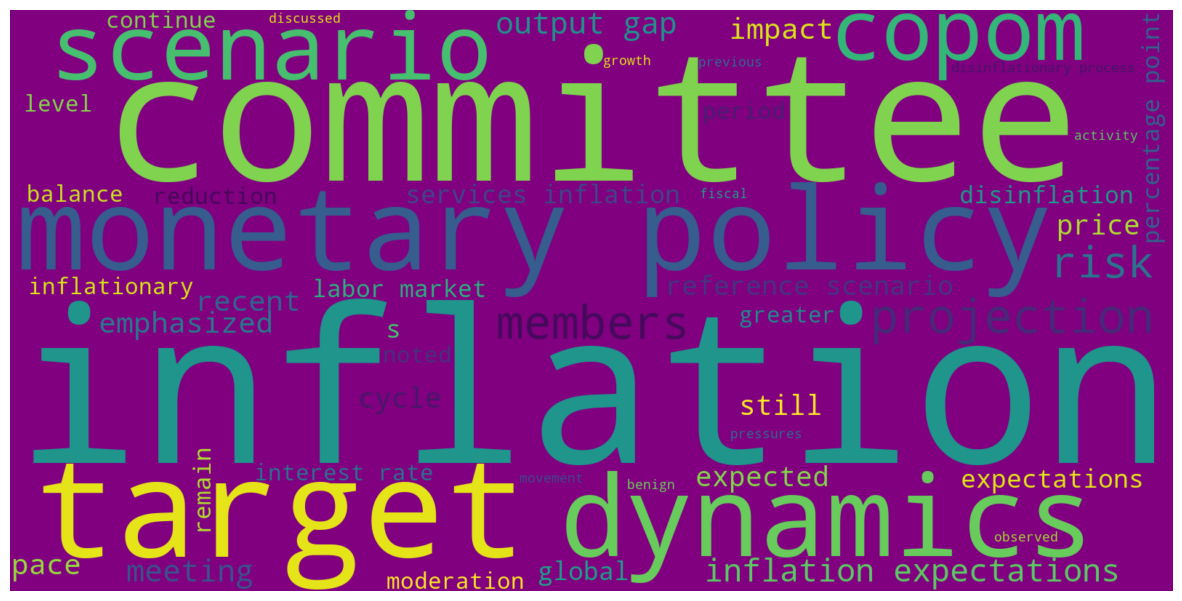

In [29]:
wordcloud_copom(minute_256[0])

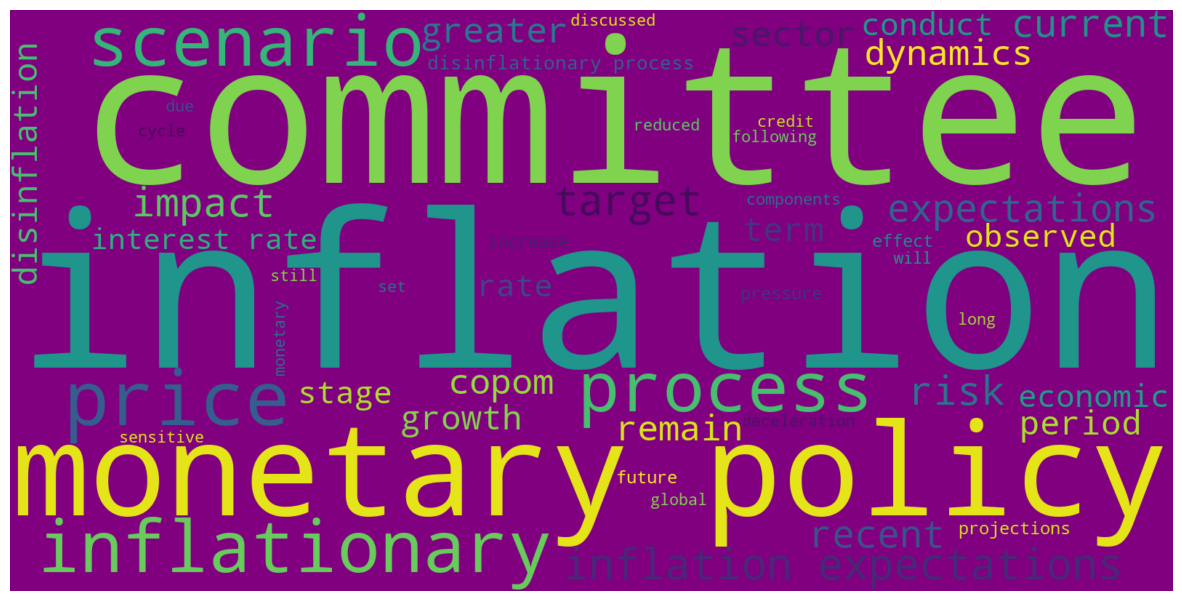

In [30]:
wordcloud_copom(minute_255[0])

#### **Comparação de frases/sentenças entre dois arquivos**

In [31]:
similaridade_sentencas(minutes_1=minute_256[2], minutes_2=minute_255[2])

O texto possui 9 tópicos.
O texto possui 10 tópicos.
------------------------------
Sentença do arquivo 1:  B) Scenarios and risk analysis4.
Sentença do arquivo 2:  B) Scenarios and risk analysis5.
Similaridade:  0.96875
------------------------------

Sentença do arquivo 1:  In the reference scenario, the interest rate path is extracted from the Focus survey, and the exchange rate starts at USD/BRL 4.752 and evolves according to the purchasing power parity (PPP).
Sentença do arquivo 2:  In the reference scenario, the interest rate path is extracted from the Focus survey, and the exchange rate starts at USD/BRL 4.852 and evolves according to the purchasing power parity (PPP).
Similaridade:  0.9947643979057592
------------------------------

Sentença do arquivo 1:  The Committee assumes that oil prices follow approximately the futures market curve for the following six months and then start increasing 2% per year onwards.
Sentença do arquivo 2:  The Committee assumes that oil prices fol

In [32]:
similaridade_sentencas_df(minutes_1=minute_256[2], minutes_2=minute_255[2])

,Sentenca_Arquivo_1,Sentenca_Arquivo_2,Similaridade
9,"Such determination, albeit with a likely impac...","Such determination, albeit with a likely impac...",1.000000
2,The Committee assumes that oil prices follow a...,The Committee assumes that oil prices follow a...,1.000000
17,The Committee emphasizes that risks to its sce...,The Committee emphasizes that risks to its sce...,1.000000
12,This movement is expected and has been accompa...,This movement is expected and has been accompa...,1.000000
1,"In the reference scenario, the interest rate p...","In the reference scenario, the interest rate p...",0.994764
0,B) Scenarios and risk analysis4.,B) Scenarios and risk analysis5.,0.968750
11,Some members noted that the recent process tow...,Some members noted that the recent process tow...,0.961702
3,"Moreover, the energy flag is assumed to be “gr...","Moreover, the energy flag is assumed to be “gr...",0.944099
13,The Committee believes that the disinflation d...,The Committee believes that the disinflation d...,0.919831
14,"In this regard, the recent dynamics of the exc...","Besides, the recent dynamics of the exchange r...",0.880000


### **Análise de Sentimento**

In [14]:
# O tópico "A" é o mais curto da ata, eu consigo analisar o sentimento dessa parte
print(sentiment_score(sentence=minute_256[1]))
print(sentiment_score_v2(sentence=minute_256[1]))

neutral
positive


* O problema da análise de sentimento é de que você não pode passar um texto muito grande. Por isso, você você tem que separar o texto da ata em partes menores.



In [55]:
# Separando o texto do tópico "B" que é maior
partes_topico_b = text_splitter(minute=minute_256[2])
partes_topico_b

['B) Scenarios and risk analysis4. In the reference scenario, the interest rate path is extracted from the Focus survey, and the exchange rate starts at USD/BRL 4.752 and evolves according to the purchasing power parity (PPP). The Committee assumes that oil prices follow approximately the futures market curve for the following six months and then start increasing 2% per year onwards. Moreover, the energy flag is assumed to be “green” in December 2023, 2024, and 2025. In this scenario, Copom’s inflation projections stand at 4.9% for 2023, 3.4% for 2024, and 3.0% for 2025. Inflation projections for administered prices are 9.4% for 2023, 4.6% for 2024, and 3.5% for 2025.',
 '5. The Committee evaluates that the international outlook is uncertain. The Committee noted the resilience of activity and the labor market in advanced economies, even if some moderation is observed at the margin, as well as lower growth projection for the Chinese economy. In this context some members see a mild moder

In [84]:
# Após separar o tópico "B" em várias sentenças, eu posso analisar o sentimento de cada sentença
print(sentiment_score(sentence=partes_topico_b[2]))
print(sentiment_score_v2(sentence=partes_topico_b[2]))


positive
positive


In [81]:
# Analisando o sentimento de todas as sentenças separadas ao mesmo tempo
text_splitter_sentiment_analysis(minute=minute_256[2])

De 15 sentenças:
- Nº de sentenças positivas: 8
- Nº de sentenças negativas: 0
- Nº de sentenças neutras: 7


### **Lendo o arquivo PDF**

* O principal problema de fazer a extração do texto de um arquivo PDF são os textos, palavras e números no rodapé da página.

In [2]:
from pypdf import PdfReader

In [ ]:
dict_minutes = {}

for num_minutes in range(250, 257):
    pdf_file_path = f'C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_{num_minutes}.pdf'
    reader = PdfReader(pdf_file_path)
    page = reader.pages[2]
    minutes_text = page.extract_text()
    dict_minutes[num_minutes] = minutes_text.strip()

dict_minutes

In [ ]:
IPython.display.Markdown(dict_minutes[250])

**Removendo as notas de rodapé e textos das bordas do PDF**

In [ ]:
# https://pypdf.readthedocs.io/en/stable/user/post-processing-in-text-extraction.html

reader = PdfReader('C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_256.pdf')
page = reader.pages[3]

parts = []

def visitor_body(text, cm, tm, font_dict, font_size):
    y = tm[5]

    if y > 110 and y < 750:
        parts.append(text)


page.extract_text(visitor_text=visitor_body)
text_body = "".join(parts)

print(text_body)

In [ ]:
import fitz  # PyMuPDF

def extract_text_and_remove_footnotes(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""

    for page_num in range(len(doc)):
        page = doc[page_num]
        page_text = page.get_text()

        # Verificar o tamanho da fonte para identificar notas de rodapé
        if page.annots():
            for annot in page.annots():
                if annot.info['size'] < 3:  # Ajuste o valor conforme necessário
                    page_text = page_text.replace(annot.info['content'], '')

        text += page_text

    return text

# Exemplo de uso:
pdf_path = 'C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_256.pdf'
texto_extraido = extract_text_and_remove_footnotes(pdf_path)
print(texto_extraido)


In [101]:
import fitz  # PyMuPDF

# Abra o arquivo PDF
pdf_file_path = 'C://Users//vitor//projetos_python//python_b3//historico-arquivos//minutes-pdf//minutes_256.pdf'
doc = fitz.open(pdf_file_path)

toc = doc.get_toc()
toc
 

[[1, 'Minutes of the Meeting of the', 1],
 [2, 'A) Update of economic outlook and Copom’s scenario0F', 3],
 [2, 'B) Scenarios and risk analysis', 3],
 [2, 'C) Discussion about the conduct of monetary policy', 5],
 [2, 'D) Monetary policy decision', 7]]